In [1]:
import pandas as pd
import numpy as np
from pandas_ods_reader import read_ods
import re
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

from scipy.stats import ttest_rel
from scipy.stats import ttest_ind

In [2]:
fpath = 'izev-wsts-_september_2022_stats_for_web_publishing-en.ods'

sheet_index = 1
dfinc = read_ods(fpath, sheet_index)

fpath2 = '20100024.csv' 
dfreg = pd.read_csv(fpath2)

fpath3 = 'provinces.csv'
dfprov = pd.read_csv(fpath3, index_col = 'Name')


In [3]:
test = dfreg.copy()
test['REF_DATE'].replace('\d\d\d\d-', '', regex = True, inplace = True)
test['REF_DATE']=test['REF_DATE'].astype('int32')

test = test.loc[test['GEO']=='Canada'].groupby(['REF_DATE']).sum().reset_index()

regfraction = (test['VALUE'].sum())/(test.loc[1,'VALUE'] + test.loc[0,'VALUE'])

In [4]:
test2 = dfinc.copy()
test2.loc[test2['Calendar Year'].isin([2020,2021])]
test2['Month and Year '].replace(' .*', '', regex = True, inplace = True)

monthmap = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}

test2['Month and Year '] = test2['Month and Year '].map(monthmap)

test2 = test2.groupby(['Month and Year ']).sum().reset_index()

incfraction2019 = test2['Eligible Incentive Amount'].sum()/test2.loc[5:12,'Eligible Incentive Amount'].sum()
incfraction2022 = test2['Eligible Incentive Amount'].sum()/test2.loc[1:9,'Eligible Incentive Amount'].sum()


In [5]:
provmap = {'British Columbia':'British Columbia and the Territories'
           , 'Northwest Territories':'British Columbia and the Territories'
           , 'Yukon':'British Columbia and the Territories'
           , 'Quebec':'Quebec'
           , 'Ontario':'Ontario'
           , 'Manitoba':'Manitoba'
           , 'New Brunswick':'New Brunswick'
           , 'Saskatchewan':'Saskatchewan'
           , 'Nova Scotia':'Nova Scotia'
           , 'Alberta':'Alberta'
           , 'Prince Edward Island':'Prince Edward Island'
           , 'Newfoundland and Labrador':'Newfoundland and Labrador'}

popmap = dfprov['Population Total'].to_dict()

provlist = ['Prince Edward Island', 'New Brunswick', 'Quebec', 'Ontario', 'Manitoba', 'Saskatchewan', 'British Columbia and the Territories']
yearlist = [2019,2020,2021,2022]
          

dfinc['Recipient Province / Territory ']=dfinc['Recipient Province / Territory '].map(provmap)

In [6]:
dfinc['Calendar Year']=dfinc['Calendar Year'].astype('int32')
dfreg['REF_DATE'].replace('-\d\d', '', regex = True, inplace = True)
dfreg['REF_DATE']=dfreg['REF_DATE'].astype('int32')

In [7]:
incentive = dfinc.iloc[:,[3,7,10,11]]
incentive.columns=['Year','Type','Total Incentive','Province']
incentive = incentive.loc[incentive['Province'].isin(provlist)]

In [8]:
register = dfreg.iloc[:,[0,1,3,12]]
register.columns=['Year','Province','Type','Registrations']
register = register.loc[register['Province'].isin(provlist)]

In [9]:
register['Type'] = register['Type'].map({'All fuel types':'Not EV', 'Gasoline':'Not EV', 'Diesel':'Not EV', 'Battery electric':'EV',
       'Hybrid electric':'EV', 'Plug-in hybrid electric':'EV', 'Other fuel types':'Not EV'})

In [10]:
finalreg = register.groupby(['Province','Year','Type'])['Registrations'].apply('sum').reset_index()
finalinc = incentive.groupby(['Province','Year']).sum().reset_index()

In [11]:
finalreg['Population'] = finalreg['Province'].map(popmap)
finalreg['Reg/Pop'] = finalreg['Registrations']/finalreg['Population']

In [12]:
finaldf = pd.merge(finalreg, finalinc, on=['Province', 'Year'], how = 'outer').fillna(0)

def incMap(n):
    if n == 0:
        return 'No'
    else:
        return 'Yes'          

finaldf['Is Incentive'] = finaldf['Total Incentive'].map(incMap)
finaldf['Inc/Pop'] = finaldf['Total Incentive']/finaldf['Population']

In [13]:
finaldf.loc[finaldf['Year'] == 2022,'Registrations'] *= regfraction
finaldf.loc[finaldf['Year'] == 2022,'Reg/Pop'] *= regfraction
# finaldf.loc[finaldf['Year'] == 2022,'Inc/Pop'] *= incfraction2022
# finaldf.loc[finaldf['Year'] == 2019,'Inc/Pop'] *= incfraction2019
finaldf.loc[finaldf['Year'] == 2022,'Inc/Pop'] *= 3/2
finaldf.loc[finaldf['Year'] == 2019,'Inc/Pop'] *= 4/3

In [14]:
er = finaldf.loc[finaldf['Type']=='EV'].reset_index()['Registrations']/finaldf.loc[finaldf['Type']=='Not EV'].reset_index()['Registrations']

finaldf['EV/Reg'] = np.repeat(er.values,2)

---

# Electric Vehicle Incentives Analysis


---

## Table of Contents

1. Objectives
1. Data Preparation
1. Initial Analysis
1. Linear Regression
1. Hypothesis Testing
1. Conclusions


---

## Objectives

We wanted to discover how effective the Incentives for Zero-Emission Vehicles (iZEV) program has been at encouraging Canadian consumers to purchase electric vehicles as apposed to traditional ones. The data that we were interested in analyzing were data related to the number of vehicles registered in Canada in the years before and after the IZEV program was intruduced. We also wanted to look at how popular the iZEC program is, how much it has been used and how the incentives offered through the program have been related to the change in vehicle registrations.

After obtaining the data, we wanted to analyze it to determine whether or not the incentives have been successful at playing a significant role in the change in electric vehicle purchasing trends. Ideally it would be possible to use hypothesis tests to determine the likelihood of iZEV incentives causing an increasing in electric cehicle purchases by comparing the purchasing behaviour before and after the incentives became available. 


<br>
<br>

---

## Data Preparation

Data about new vehicle registrations in Canada was retrieved from Statistics Canada. The data included the number of vehicle registrations in each province, for the years 2017-2022, sorted by vehicle type. Data was not available for Alberta, Newfoundland or New Brunswick. The data was downloaded as a .csv file from the Statistics Canada website[^1]. 

Data related to the economic incentives granted by the iZEV program was also retrieved from the government of Canada's Open Government Portal. The data summarizes all instances of incentives recieved by consumers, sorted by province and vehicle type. The data was also downloaded as a .csv file from the Government of Canada Open Government website [^2].

In order to standardize the registrations and incentives, since the different provinces were going to be used as data points, the populations of the provinces was retrieved from Wikipedia [^3].


The data was wrangled in order to produce a table where each observation represents one province for one year. Because each province has significantly different populations, new variables were introduced. A variable for the fraction of all vehicle registrations that were electric vehicles was calculated, as well as a variable representing the number of registrations per capita. The final dataframe can be seen below in the [Appendix: Data Samples](#Appendix:-Data-Samples)

The data for each year were not all complete, so the final values had to be changed to compensate. The vehicle registrations data was missing the last two quarters of 2022, and the financial incentives data was missing the first four months of 2019, and the last 3 months of 2022. We examined if there were any patterns in vehicle registrations and iZEV incentives recieved from the complete years in order to determine how to recalculate the values for 2019 and 2022. Below are plots of the distributions of registrations per quarter, and incentives per months. Because of the general pattern of increased registrations and incentives during the middle of the year, the values for the registrations in the final data set were adjusted to compensate for this relationship. Below is the results of an ANOVA test for the registrations and the incentives, and it can be seen that in the case of the registrations, there is a significant result that the quarters are not identical, and therefore the values were used to compute the final values, whereas the incentives were treated as if the months were identical.  

[^1]: Government of Canada, Statistics Canada. (2022, October 11). New Motor Vehicle Registrations, quarterly. Government of Canada, Statistics Canada. Retrieved December 9, 2022, from https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=2010002401 
[^2]: Statistics on the incentives for zero-emission vehicles (iZEV) program - statistics on the incentives for zero-emission vehicles program (iZEV) - Data Dictionary. Open Government Portal. (n.d.). Retrieved December 9, 2022, from https://open.canada.ca/data/en/dataset/42986a95-be23-436e-af15-7c6bf292a2e1/resource/12a8a111-d790-49ce-af7c-ec388345e147 
[^3]: Wikimedia Foundation. (2022, October 19). Population of Canada by province and territory. Wikipedia. Retrieved December 9, 2022, from https://en.wikipedia.org/wiki/Population_of_Canada_by_province_and_territory 

In [15]:
test3 = dfreg.copy()
test3['REF_DATE'].replace('\d\d\d\d-', '', regex = True, inplace = True)
test3['REF_DATE']=test3['REF_DATE'].astype('int32')
anov = ols('VALUE ~ REF_DATE', data=test3).fit()
anova_table = sm.stats.anova_lm(anov, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
REF_DATE,8.450503e+09,1.0,3.912846,0.047963
Residual,1.329932e+13,6158.0,NaN,NaN


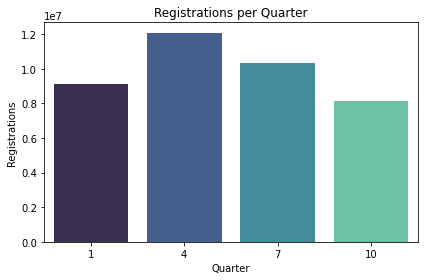

In [16]:
plot = sns.barplot(data = test, x = 'REF_DATE', y = 'VALUE', palette = sns.color_palette("mako", 4))
plot.set(title='Registrations per Quarter')
plot.set(xlabel='Quarter', ylabel='Registrations')
plt.tight_layout()   
plt.show()

In [17]:
# test2 = dfinc.copy()
# test2.loc[test2['Calendar Year'].isin([2020,2021])]
# test2['Month and Year '].replace(' .*', '', regex = True, inplace = True)

# monthmap = {'January':1,'February':2,'March':3,'April':4,'May':5,'June':6,'July':7,'August':8,'September':9,'October':10,'November':11,'December':12}

# test2['Month and Year '] = test2['Month and Year '].map(monthmap)

# anov = ols('VALUE ~ REF_DATE', data=test).fit()
# anova_table = sm.stats.anova_lm(anov, typ=2)
# anova_table

In [18]:
test4 = dfinc.copy()
test4.loc[test4['Calendar Year'].isin([2020,2021])]
test4['Month and Year '].replace(' .*', '', regex = True, inplace = True)

monthmap = {'January':1,'February':1,'March':1,'April':2,'May':2,'June':2,'July':3,'August':3,'September':3,'October':4,'November':4,'December':4}

test4['Month and Year '] = test4['Month and Year '].map(monthmap)
test4 = test4.groupby(['Month and Year ','Calendar Year']).sum().reset_index()
test4.columns = ['Quarter','Year','Incentive']

anov = ols('Incentive ~ Quarter', data=test4).fit()
anova_table = sm.stats.anova_lm(anov, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Quarter,1.914295e+12,1.0,0.009501,0.923959
Residual,2.417717e+15,12.0,NaN,NaN


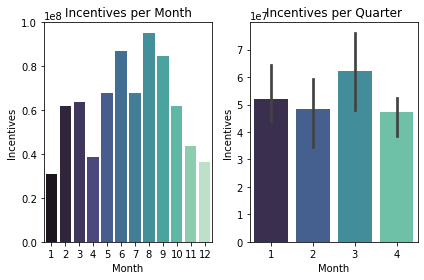

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)
plot = sns.barplot(data = test2, x = 'Month and Year ', y = 'Eligible Incentive Amount', palette = sns.color_palette("mako", 12),ax = ax1)
plot.set(title='Incentives per Month')
plot.set(xlabel='Month', ylabel='Incentives')
plt.tight_layout()   


plot = sns.barplot(data = test4, y = 'Incentive', x = 'Quarter', palette = sns.color_palette("mako", 4), ax = ax2)
plot.set(title='Incentives per Quarter')
plot.set(xlabel='Month', ylabel='Incentives')
plt.tight_layout()   


plt.show()

---

##  Initial Analysis

The first step in the analysis was to examine the trends that took place over the 2017-2022 period that was being examined. By looking first at the change in the fraction of vehicle regitrations that are EVs, and the EV and non-EV registrations per capita, several trends become clear. Not only has the fraction of vehicles that are EVS consistently been increasing, but the raw number of EV registrations per capita has been increasing, while the non-EV registrations have been decreasing. It can be seen there is a clear trend towards more  EV registrations and a higher fraction of EV vehicles. 

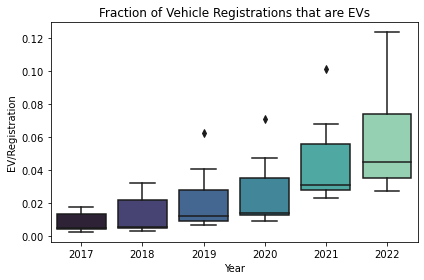

In [20]:
plot = sns.boxplot(data=finaldf.loc[finaldf['Type']=='EV'], x="Year", y="EV/Reg", palette = sns.color_palette("mako"))
plot.set(title='Fraction of Vehicle Registrations that are EVs')
plot.set(xlabel='Year', ylabel='EV/Registration')
plt.tight_layout()   
plt.show()

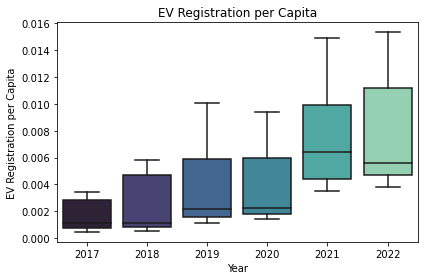

In [21]:
plot = sns.boxplot(data=finaldf.loc[finaldf['Type']=='EV'], x="Year", y="Reg/Pop", palette = sns.color_palette("mako"))
plot.set(title='EV Registration per Capita')
plot.set(xlabel='Year', ylabel='EV Registration per Capita')
plt.tight_layout()   
plt.show()

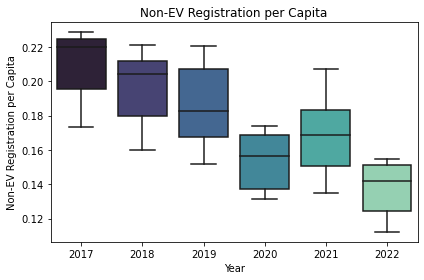

In [22]:
plot = sns.boxplot(data=finaldf.loc[finaldf['Type']=='Not EV'], x="Year", y="Reg/Pop", palette = sns.color_palette("mako"))
plot.set(title='Non-EV Registration per Capita')
plot.set(xlabel='Year', ylabel='Non-EV Registration per Capita')
plt.tight_layout()   
plt.show()

We can also see that the total incentives recieved has not remained constant after they were initially implemented, as an ANOVA test shows that they are unlikely to have the same mean.

In [23]:
dfcopy = finaldf.copy()
dfcopy.columns = ['Province', 'Year', 'Type', 'Registrations', 'Population', 'RegPop', 'Total Incentive', 'Is Incentive', 'IncPop', 'EVReg']


anov = ols('RegPop ~ Year', data=dfcopy.loc[(finaldf['Type']=='EV')&(finaldf['Year'].isin([2019,2020,2021,2022]))]).fit()
anova_table = sm.stats.anova_lm(anov, typ=2)
anova_table



,sum_sq,df,F,PR(>F)
Year,0.000086,1.0,5.508144,0.026821
Residual,0.000404,26.0,NaN,NaN


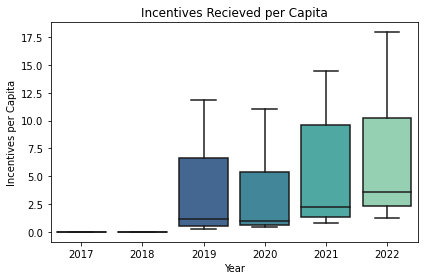

In [24]:
plot = sns.boxplot(data=finaldf.loc[finaldf['Type']=='EV'], x="Year", y="Inc/Pop", palette = sns.color_palette("mako"))
plot.set(title='Incentives Recieved per Capita')
plot.set(xlabel='Year', ylabel='Incentives per Capita')
plt.tight_layout()   
plt.show()

---

## Linear Regression

If we examine linear plots of the fraction of EV registrations compared to incentives per capita, we can see that there is a strong linear relationship between the two. There is an even stronger linear relationship between the EV reigstrations per capita and the incentives per capita, but this is not a very surprising result: the EV registrations per capita must increase with the incentives per capita because the incentives can only increase when people buy (and then register) an electric vehicle, but it is not so straightforward that the incentives should scale with the EV fraction. This relationship suggests that as more people purchase electric vehicles and recieve incentives for them, EV vehicles are simultaneously becoming more popular relative to conventional vehicles. 

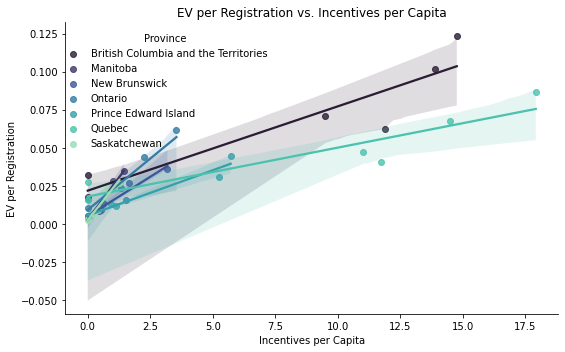

In [40]:
plot = sns.lmplot(data = finaldf.loc[finaldf['Type']=='EV'], x = 'Inc/Pop', y = 'EV/Reg', hue = 'Province', palette = sns.color_palette("mako", 7))
plot.set(title='EV per Registration vs. Incentives per Capita')
plot.set(xlabel='Incentives per Capita', ylabel='EV per Registration')
sns.move_legend(plot, "lower left", bbox_to_anchor=(.10, .55))
plt.tight_layout() 
plt.show()

# plot = sns.lmplot(data = finaldf.loc[finaldf['Type']=='EV'], x = 'Inc/Pop', y = 'Reg/Pop', hue = 'Province', palette = sns.color_palette("mako", 7))
# plot.set(title='Registrations per Capita vs. Incentives per Capita')
# plot.set(xlabel='Incentives per Capita', ylabel='Registrations Per Capita')
# sns.move_legend(plot, "lower left", bbox_to_anchor=(.10, .55))
# plt.tight_layout() 
# plt.show()

In [44]:
x = finaldf.loc[finaldf['Type']=='EV']['Inc/Pop']
y = finaldf.loc[finaldf['Type']=='EV']['EV/Reg']

x = sm.add_constant(x)
results2 = sm.OLS(y,x).fit()
results2.summary(slim = True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 EV/Reg   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.769
No. Observations:                  42   F-statistic:                     137.7
Covariance Type:            nonrobust   Prob (F-statistic):           1.58e-14
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0132      0.003      5.278      0.000       0.008       0.018
Inc/Pop        0.0049      0.000     11.734      0.000       0.004       0.006
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# x = finaldf.loc[finaldf['Type']=='EV']['Inc/Pop']
# y = finaldf.loc[finaldf['Type']=='EV']['Reg/Pop']

# x = sm.add_constant(x)
# results2 = sm.OLS(y,x).fit()
# results2.summary() 

In [28]:
# fig = plt.figure(figsize=(6,6))
# sm.graphics.plot_regress_exog(results2, 'Inc/Pop', fig = fig)

# fig, ax = plt.subplots(figsize=(4, 4))
# plot = sm.qqplot(results2.resid, stats.t, fit=True, line="45",  ax = ax)
# plt.tight_layout()   
# plt.show()

---

## Hypothesis Testing

If we compare the distributions of EV and non-EV vehicles per capita registration, depending on whether they were registered during a period of time that the iZEV incentives were in place, it is possible to see that EV registrations are higher after the incentives came into place, and non-EV registrations were lower. This all combines to give us some motivation to determine if the incentives were specifically influenced by the iZEV incentives. The below t-tests show that there is a significant difference in the mean of the fraction of EV registrations before and after the incentives with an $\alpha$ = 0.05. There is also significant result showing an increase in the EV registrations per capita, and a decrease in the non-EV registrations per capita over the same time periods. 

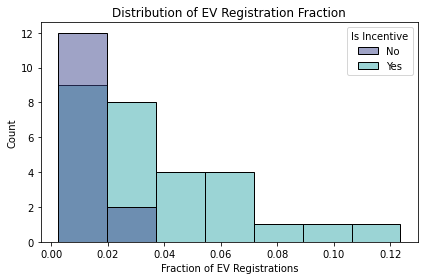

In [29]:
copy = finaldf.copy()
# copy['EV/Reg']=np.sqrt(copy['EV/Reg'])

# fig, (ax1, ax2) = plt.subplots(1, 2)

plot = sns.histplot(data = copy.loc[copy['Type']=='EV'], x = 'EV/Reg', hue = 'Is Incentive', palette = sns.color_palette("mako", 2))
plot.set(title='Distribution of EV Registration Fraction')
plot.set(xlabel='Fraction of EV Registrations', ylabel='Count')


# plot = sns.histplot(data = copy.loc[copy['Type']=='Not EV'], x = 'EV/Reg', hue = 'Is Incentive', palette = sns.color_palette("mako", 2), ax = ax2)
# plot.set(title='Distribution of Non-EV Registrations Fraction')
# plot.set(xlabel='Fraction of EV Registrations', ylabel='Count')


plt.tight_layout() 
plt.show()

In [30]:
a = finaldf.loc[(finaldf['Type'] == 'EV') & (finaldf['Is Incentive'] == 'Yes')]['EV/Reg']
b = finaldf.loc[(finaldf['Type'] == 'EV') & (finaldf['Is Incentive'] == 'No')]['EV/Reg']

d = {'T-test Statistic': [ttest_ind(a,b)[0]], 'p Value': [ttest_ind(a,b)[1]]}
df = pd.DataFrame(data=d)
df

,T-test Statistic,p Value
0,3.343128,0.001807


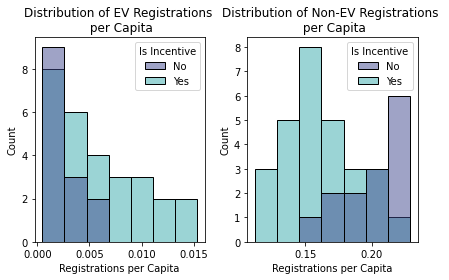

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2)

plot = sns.histplot(data = finaldf.loc[finaldf['Type']=='EV'], x = 'Reg/Pop', hue = 'Is Incentive', palette = sns.color_palette("mako", 2), ax = ax1)
plot.set(title='Distribution of EV Registrations \n per Capita')
plot.set(xlabel='Registrations per Capita', ylabel='Count')


plot = sns.histplot(data = finaldf.loc[finaldf['Type']=='Not EV'], x = 'Reg/Pop', hue = 'Is Incentive', palette = sns.color_palette("mako", 2), ax = ax2)
plot.set(title='Distribution of Non-EV Registrations \n per Capita')
plot.set(xlabel='Registrations per Capita', ylabel='Count')


plt.tight_layout() 
plt.show()

In [32]:
a = finaldf.loc[(finaldf['Type'] == 'EV') & (finaldf['Is Incentive'] == 'Yes')]['Reg/Pop']
b = finaldf.loc[(finaldf['Type'] == 'EV') & (finaldf['Is Incentive'] == 'No')]['Reg/Pop']

d = {'T-test Statistic': [ttest_ind(a,b)[0]], 'p Value': [ttest_ind(a,b)[1]]}
df = pd.DataFrame(data=d)
df

,T-test Statistic,p Value
0,3.147916,0.003104


In [33]:
a = finaldf.loc[(finaldf['Type'] == 'Not EV') & (finaldf['Is Incentive'] == 'Yes')]['Reg/Pop']
b = finaldf.loc[(finaldf['Type'] == 'Not EV') & (finaldf['Is Incentive'] == 'No')]['Reg/Pop']

d = {'T-test Statistic': [ttest_ind(a,b)[0]], 'p Value': [ttest_ind(a,b)[1]]}
df = pd.DataFrame(data=d)
df

,T-test Statistic,p Value
0,-4.796601,0.000023


However, looking at year-to-year comparisons instead of simply comparing the before and after periods shows that there is no significant difference in the jump from 2018 to 2019 - or in an individual year - which casts doubt on the idea that the iZEV incentives are specifically responsible for the difference noted above, instead of simply the trend of increased popularity of EV that can be seen in the yearly registration data.

In [34]:
t = []
for y in [2017,2018,2019,2020,2021]:
    a = finaldf.loc[(finaldf['Type'] == 'EV') & (finaldf['Year'] == y)]['EV/Reg']
    b = finaldf.loc[(finaldf['Type'] == 'EV') & (finaldf['Year'] == y+1)]['EV/Reg']
    t.append(ttest_ind(a,b)[1])

d = {'Years': ['2017-2018','2018-2019','2019-2020','2020-2021','2021-2022'], 'p Value of T-test': t}
df = pd.DataFrame(data=d)
df

,Years,p Value of T-test
0,2017-2018,0.345220
1,2018-2019,0.368296
2,2019-2020,0.680797
3,2020-2021,0.200511
4,2021-2022,0.459965


In [35]:
t = []
for y in [2017,2018,2019,2020,2021]:
    a = finaldf.loc[(finaldf['Type'] == 'EV') & (finaldf['Year'] == y)]['Reg/Pop']
    b = finaldf.loc[(finaldf['Type'] == 'EV') & (finaldf['Year'] == y+1)]['Reg/Pop']
    t.append(ttest_ind(a,b)[1])
    
d = {'Years': ['2017-2018','2018-2019','2019-2020','2020-2021','2021-2022'], 'p Value of T-test': t}
df = pd.DataFrame(data=d)
df

,Years,p Value of T-test
0,2017-2018,0.394222
1,2018-2019,0.407797
2,2019-2020,0.983043
3,2020-2021,0.114218
4,2021-2022,0.851350


---

## Conclusions

While it is certainly the case that electric vehicles have increased in popularity over the years from 2017-2022, and there is a correlation between the increase and the iZEV incentive program, there does not appear to be strong evidence that the incentive program itself had a significant effect. If it had had an effect, we would probably expect to see a particularly large increase in EV registrations in the year or two after they came into effect, and while there is an increase, there does not seem to be anything special about the jump from 2018-2019. 

<br>
<br>
<br>
<br>

---

## Appendix: Data Samples

In [52]:
finaldf.head(5)

,Province,Year,Type,Registrations,Population,Reg/Pop,Total Incentive,Is Incentive,Inc/Pop,EV/Reg
0,British Columbia and the Territories,2017,EV,16888.0,5082181,0.003323,0.000000e+00,No,0.000000,0.017339
1,British Columbia and the Territories,2017,Not EV,973984.0,5082181,0.191647,0.000000e+00,No,0.000000,0.017339
2,British Columbia and the Territories,2018,EV,28828.0,5082181,0.005672,0.000000e+00,No,0.000000,0.032335
3,British Columbia and the Territories,2018,Not EV,891544.0,5082181,0.175425,0.000000e+00,No,0.000000,0.032335
4,British Columbia and the Territories,2019,EV,51156.0,5082181,0.010066,4.532182e+07,Yes,11.890387,0.062321


In [46]:
finaldf.tail(5)

,Province,Year,Type,Registrations,Population,Reg/Pop,Total Incentive,Is Incentive,Inc/Pop,EV/Reg
79,Saskatchewan,2020,Not EV,177132.000000,1132505,0.156407,449374.999988,Yes,0.396797,0.009055
80,Saskatchewan,2021,EV,4014.000000,1132505,0.003544,875000.000000,Yes,0.772624,0.022892
81,Saskatchewan,2021,Not EV,175342.000000,1132505,0.154827,875000.000000,Yes,0.772624,0.022892
82,Saskatchewan,2022,EV,4326.815478,1132505,0.003821,955000.000000,Yes,1.264895,0.026940
83,Saskatchewan,2022,Not EV,160607.803536,1132505,0.141816,955000.000000,Yes,1.264895,0.026940
